# Análise Preditiva de Vendas (Sales Forecasting)

## 1. Introdução e Objetivo

Bem-vindo ao projeto de Análise Preditiva de Vendas!

Neste notebook, desenvolveremos um modelo de *machine learning* de ponta a ponta para prever tendências de vendas. O objetivo principal é utilizar dados históricos de transações para criar um sistema de forecasting que auxilie em decisões estratégicas, como otimização de estoque e planejamento financeiro.

Este projeto faz parte da construção de um portfólio de elite em Engenharia de IA e Ciência de Dados e seguirá a metodologia "Aprender Construindo".

---

## 2. O Dataset

Para este estudo de caso, utilizaremos o dataset **Retail Sales Forecasting** disponível na plataforma Kaggle.

- **Fonte:** [Retail Sales Forecasting - Kaggle](https://www.kaggle.com/datasets/arlistle/retail-sales-forecasting)
- **Descrição:** O conjunto de dados contém um vasto histórico de vendas de um grande varejista brasileiro. Ele foi anonimizado para proteger a identidade da empresa e inclui informações sobre múltiplas lojas e SKUs (Stock Keeping Units). A granularidade dos dados nos permitirá explorar padrões sazonais e tendências ao longo do tempo.

---

## 3. Stack de Tecnologias

A solução será desenvolvida utilizando as seguintes tecnologias:

- **Linguagem de Programação:** Python
- **Bibliotecas de Análise e Modelagem:**
    - `pandas` e `numpy` para manipulação de dados.
    - `matplotlib` e `seaborn` para visualizações exploratórias iniciais.
    - `scikit-learn` para pré-processamento de dados e avaliação de modelos.
    - `Prophet` (desenvolvido pelo Facebook) para modelagem de séries temporais.
- **Ferramenta de Visualização (BI):** Tableau Public para a criação de dashboards interativos.
- **Ambiente de Desenvolvimento:** Google Colab, aproveitando a gratuidade de recursos, incluindo GPUs.
- **Controle de Versão:** Git e GitHub para versionamento do código e colaboração.

---

## 4. Metodologia

Seguiremos uma abordagem estruturada:

1.  **Análise Exploratória de Dados (EDA):** Investigar os dados para entender suas características, identificar tendências, sazonalidades e anomalias.
2.  **Pré-processamento e Feature Engineering:** Limpar e transformar os dados para prepará-los para a modelagem.
3.  **Modelagem Preditiva:** Treinar e avaliar diferentes modelos de forecasting, com foco no Prophet.
4.  **Visualização dos Resultados:** Criar um dashboard no Tableau para apresentar as previsões e insights de forma clara e interativa.
5.  **Versionamento:** Disponibilizar o projeto final em um repositório no GitHub.

Vamos começar! Nosso próximo passo será carregar os dados e iniciar a Análise Exploratória.

In [1]:
# Célula 1: Instalação das Bibliotecas
# O Prophet pode não vir pré-instalado em todos os ambientes do Colab.
# Usamos o 'pip install' para garantir que ele esteja disponível.

!pip install prophet

In [1]:
# Célula 2: Importação das Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from google.colab import drive # Adicionamos a importação do drive

# Configurações de visualização para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('figure', figsize=(16, 6))
plt.rc('font', size=14)

In [2]:
# Célula 3: Montagem do Google Drive
# Este comando conecta o ambiente do Colab ao seu Google Drive.

drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Célula 4 (Corrigida): Carregando o Dataset do Google Drive

# --- IMPORTANTE: AJUSTE O CAMINHO ABAIXO ---
# O caminho anterior apontava para uma pasta.
# Adicionamos o nome do arquivo "Sales.csv" ao final do caminho.
# Se o seu arquivo tiver outro nome, ajuste-o aqui.

caminho_do_arquivo = '/content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Análise Preditiva de Vendas (Sales Forecasting)/mock_kaggle.csv'
try:
    df_sales = pd.read_csv(caminho_do_arquivo)
    print("Dataset carregado com sucesso do Google Drive!")
    display(df_sales.head())
except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho especificado: {caminho_do_arquivo}")
    print("Verifique se o nome do arquivo e o caminho da pasta estão corretos.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Dataset carregado com sucesso do Google Drive!


,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


In [8]:
# Célula 5: Análise Inicial da Estrutura dos Dados

if 'df_sales' in locals():
    # .info() nos dá um resumo conciso do DataFrame, incluindo os tipos de dados e valores não nulos.
    print("Informações Gerais do DataFrame:")
    df_sales.info()

    print("\n" + "="*50 + "\n")

    # .isnull().sum() conta a quantidade de valores nulos em cada coluna.
    print("Contagem de Valores Ausentes por Coluna:")
    print(df_sales.isnull().sum())

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


Contagem de Valores Ausentes por Coluna:
data       0
venda      0
estoque    0
preco      0
dtype: int64


In [14]:
# Célula 6 (Corrigida Novamente): Pré-processamento e Limpeza dos Dados

if 'df_sales' in locals():
    # 1. Usamos o nome da coluna de data correto: 'data' (minúsculo)
    # 2. Mantemos o formato que já havíamos corrigido: '%Y-%m-%d'
    try:
        df_sales['data'] = pd.to_datetime(df_sales['data'], format='%Y-%m-%d')

        # O Prophet exige 'ds' e 'y'.
        # 3. Corrigimos o rename para usar os nomes de coluna corretos: 'data' e 'venda'
        df_prophet = df_sales.rename(columns={'data': 'ds', 'venda': 'y'})

        # Agrupamos os dados por dia para garantir que haja apenas uma entrada por data.
        df_prophet = df_prophet.groupby('ds')['y'].sum().reset_index()

        print("Dados pré-processados e prontos para o Prophet:")
        display(df_prophet.head())

    except KeyError as e:
        print(f"Erro de chave: {e}. Verifique se os nomes das colunas ('data', 'venda') correspondem exatamente ao seu arquivo CSV.")
    except ValueError as e:
        print(f"Erro ao converter a data: {e}. Verifique se o formato da data está correto.")

Dados pré-processados e prontos para o Prophet:


,ds,y
0,2014-01-01,0
1,2014-01-02,70
2,2014-01-03,59
3,2014-01-04,93
4,2014-01-05,96


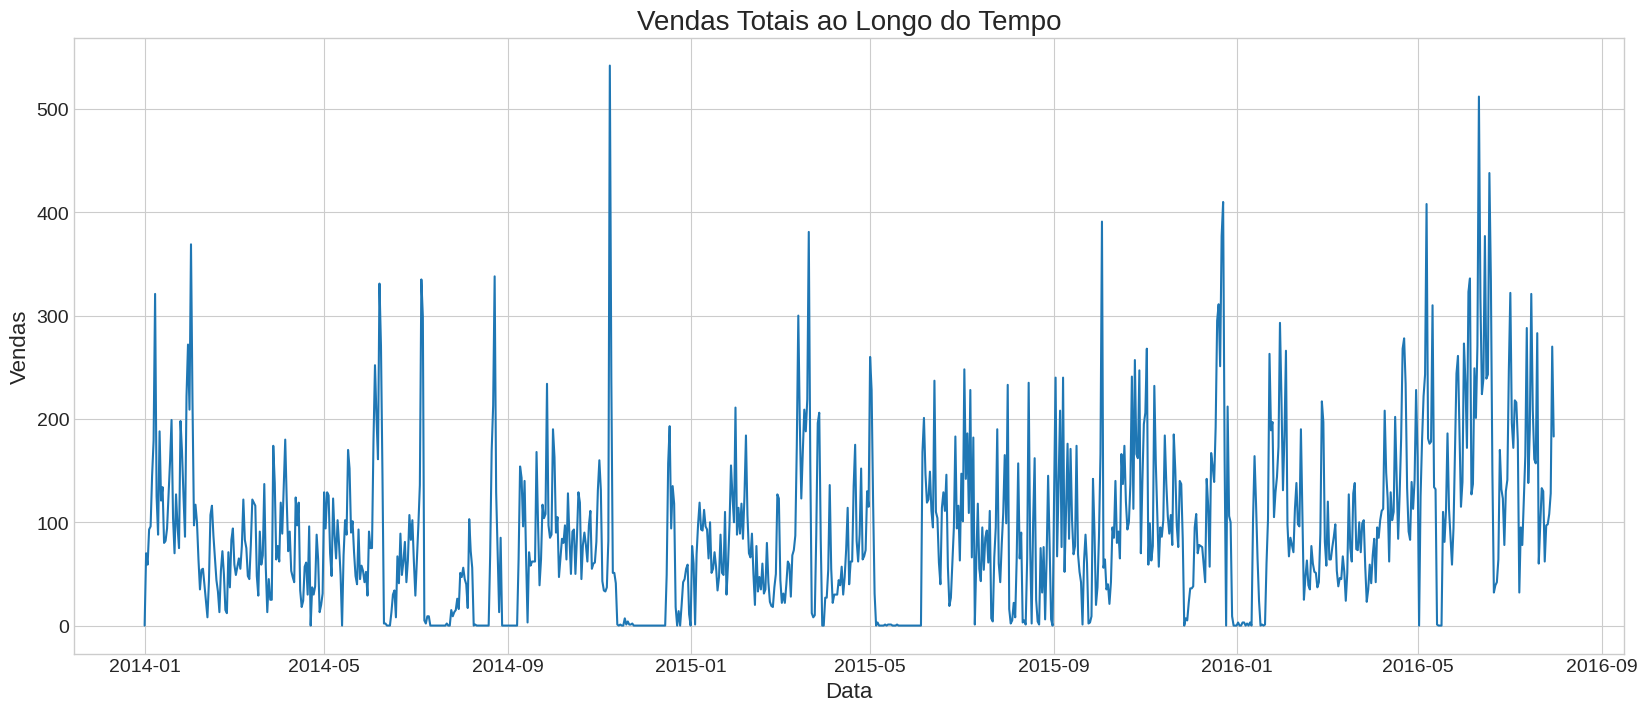

In [15]:
# Célula 7: Visualização da Série Temporal

if 'df_prophet' in locals():
    plt.figure(figsize=(20, 8))
    sns.lineplot(x='ds', y='y', data=df_prophet)

    plt.title('Vendas Totais ao Longo do Tempo', fontsize=20)
    plt.xlabel('Data', fontsize=16)
    plt.ylabel('Vendas', fontsize=16)
    plt.grid(True)
    plt.show()

In [16]:
# Célula 8: Treinamento do Modelo Prophet

if 'df_prophet' in locals():
    # Instanciamos o modelo. Prophet irá identificar automaticamente as sazonalidades.
    # yearly_seasonality=True é ideal para dados de varejo que têm picos anuais (Natal, etc.).
    # weekly_seasonality=True captura os padrões de vendas durante a semana (ex: vendas maiores no sábado).
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

    # Treinamos o modelo com nosso DataFrame.
    # Este processo pode levar alguns segundos.
    print("Iniciando o treinamento do modelo Prophet...")
    model.fit(df_prophet)
    print("Treinamento concluído com sucesso!")

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8my_4iu/rvvu33ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8my_4iu/vcq1qst2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91549', 'data', 'file=/tmp/tmpj8my_4iu/rvvu33ge.json', 'init=/tmp/tmpj8my_4iu/vcq1qst2.json', 'output', 'file=/tmp/tmpj8my_4iu/prophet_modelhttxrl1u/prophet_model-20251011060017.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Iniciando o treinamento do modelo Prophet...


06:00:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Treinamento concluído com sucesso!


In [17]:
# Célula 9: Criação de Datas Futuras para Previsão

if 'model' in locals():
    # O método make_future_dataframe cria um DataFrame com as datas históricas e as futuras.
    # periods=365 significa que queremos prever os próximos 365 dias.
    future_dates = model.make_future_dataframe(periods=365)

    print("DataFrame com datas futuras criado. Visualizando as últimas 5 datas geradas:")
    display(future_dates.tail())

DataFrame com datas futuras criado. Visualizando as últimas 5 datas geradas:


,ds
1297,2017-07-27
1298,2017-07-28
1299,2017-07-29
1300,2017-07-30
1301,2017-07-31


In [18]:
# Célula 10: Realizando a Previsão

if 'model' in locals() and 'future_dates' in locals():
    # O método predict utiliza o DataFrame de datas futuras para gerar a previsão.
    forecast = model.predict(future_dates)

    print("Previsão gerada com sucesso! Visualizando os resultados:")
    # Vamos olhar as colunas mais importantes da previsão:
    # ds: a data
    # yhat: o valor previsto
    # yhat_lower: o limite inferior do intervalo de confiança
    # yhat_upper: o limite superior do intervalo de confiança
    display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

Previsão gerada com sucesso! Visualizando os resultados:


,ds,yhat,yhat_lower,yhat_upper
1297,2017-07-27,218.121491,133.286840,305.820104
1298,2017-07-28,228.747254,143.682563,315.754445
1299,2017-07-29,279.218302,200.005812,361.371790
1300,2017-07-30,233.008225,146.212841,321.262984
1301,2017-07-31,204.179233,114.419096,285.443489


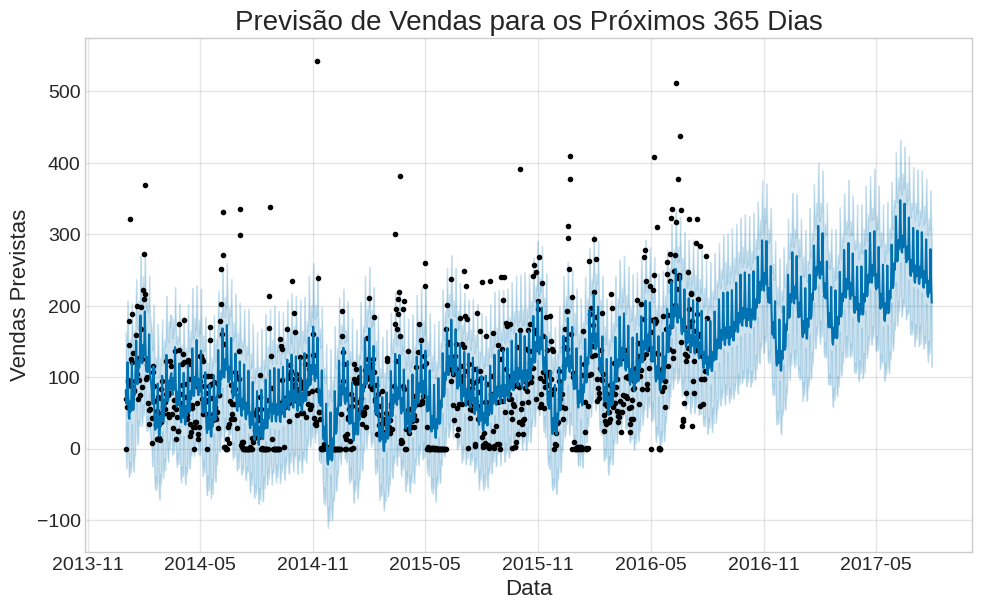

In [19]:
# Célula 11: Visualização da Previsão

if 'model' in locals() and 'forecast' in locals():
    # O método plot do Prophet gera um gráfico interativo com os resultados.
    fig1 = model.plot(forecast)

    plt.title('Previsão de Vendas para os Próximos 365 Dias', fontsize=20)
    plt.xlabel('Data', fontsize=16)
    plt.ylabel('Vendas Previstas', fontsize=16)
    plt.grid(True)
    plt.show()

Análise do Gráfico:

- **Pontos pretos:** Seus dados de vendas históricos.
- **Linha azul escura:** A previsão do modelo (yhat).
- **Área azul clara:** O intervalo de incerteza. A previsão real tem uma alta probabilidade de cair dentro desta área.

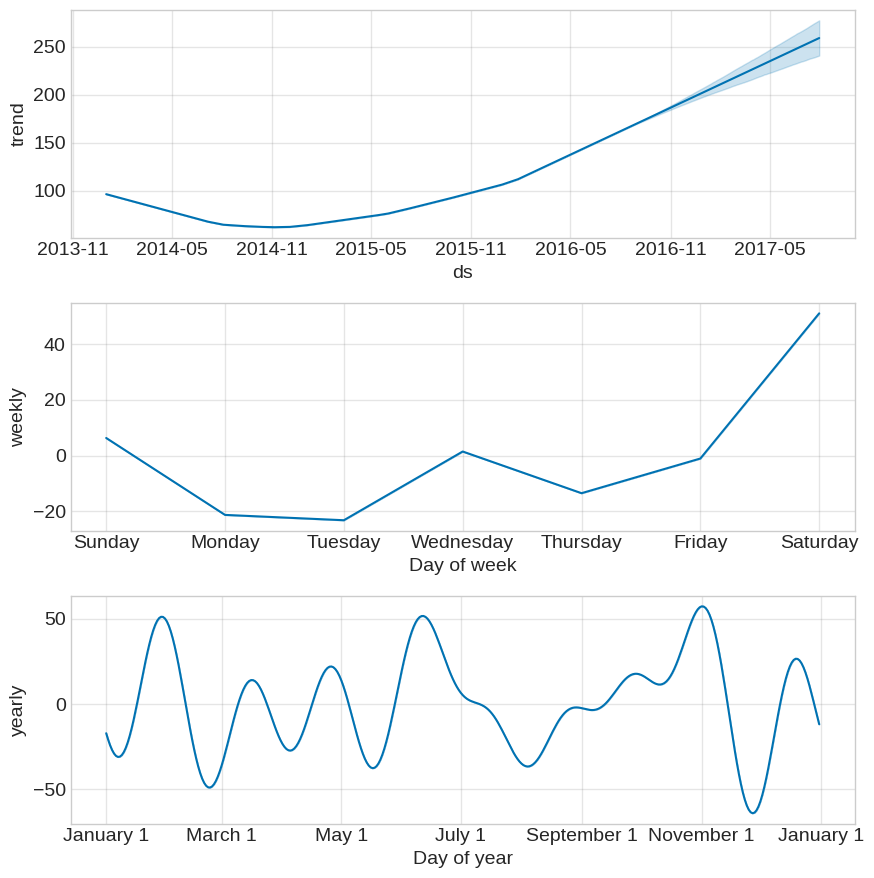

In [20]:
# Célula 12: Análise dos Componentes da Previsão

if 'model' in locals() and 'forecast' in locals():
    # O método plot_components nos ajuda a entender os padrões que o modelo aprendeu.
    fig2 = model.plot_components(forecast)
    plt.show()

Análise dos Componentes:

- **Trend (Tendência):** Mostra a tendência de crescimento de longo prazo das vendas.
- **Yearly (Sazonalidade Anual):** Revela os picos e vales que ocorrem ao longo do ano. Você provavelmente verá um pico forte no final do ano (Novembro/Dezembro).
- **Weekly (Sazonalidade Semanal):** Mostra em quais dias da semana as vendas tendem a ser mais altas ou mais baixas.

In [21]:
# Célula 13: Executando a Validação Cruzada

from prophet.diagnostics import cross_validation, performance_metrics

if 'model' in locals():
    print("Iniciando a validação cruzada...")
    # initial: período inicial de treinamento (2 anos)
    # period: a cada quanto tempo faremos uma nova previsão (a cada 6 meses)
    # horizon: até onde no futuro queremos prever (90 dias, ou 1 trimestre)
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '90 days')

    print("\nValidação cruzada concluída!")
    display(df_cv.head())

INFO:prophet:Making 1 forecasts with cutoffs between 2016-05-02 00:00:00 and 2016-05-02 00:00:00


Iniciando a validação cruzada...


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8my_4iu/t0w3gusq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj8my_4iu/hk944ush.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51282', 'data', 'file=/tmp/tmpj8my_4iu/t0w3gusq.json', 'init=/tmp/tmpj8my_4iu/hk944ush.json', 'output', 'file=/tmp/tmpj8my_4iu/prophet_model37cokhrt/prophet_model-20251011060448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:04:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:04:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Validação cruzada concluída!


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-05-03,83.463552,5.198348,162.563933,125,2016-05-02
1,2016-05-04,98.209664,21.463869,178.384118,180,2016-05-02
2,2016-05-05,83.393124,4.789716,167.798461,222,2016-05-02
3,2016-05-06,91.380096,12.842838,169.281126,243,2016-05-02
4,2016-05-07,134.945233,53.543265,215.439234,408,2016-05-02


In [22]:
# Célula 14: Calculando as Métricas de Performance

if 'df_cv' in locals():
    # Calcula as métricas de performance a partir do resultado da validação cruzada.
    df_p = performance_metrics(df_cv)

    print("Métricas de Performance (agregadas para o horizonte de 90 dias):")
    display(df_p.head())

INFO:prophet:Skipping MAPE because y close to 0


Métricas de Performance (agregadas para o horizonte de 90 dias):


,horizon,mse,rmse,mae,mdape,smape,coverage
0,9 days,24044.203314,155.061934,138.522221,0.624355,0.852427,0.111111
1,10 days,24447.554355,156.357137,142.038265,0.624355,0.891624,0.111111
2,11 days,24118.166887,155.300248,139.732026,0.624355,0.893118,0.222222
3,12 days,23479.208232,153.229267,137.222659,0.642448,1.010716,0.222222
4,13 days,21553.828300,146.812221,128.735352,0.669252,1.132174,0.222222


- **RMSE (Root Mean Squared Error):** A raiz do erro quadrático médio. Dá mais peso a erros maiores.
- **MAE (Mean Absolute Error):** O erro absoluto médio. É fácil de interpretar, pois está na mesma unidade das vendas.
- **MAPE (Mean Absolute Percentage Error):** O erro percentual absoluto médio. Ótimo para comunicar o resultado para stakeholders ("nosso modelo erra, em média, X%").

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


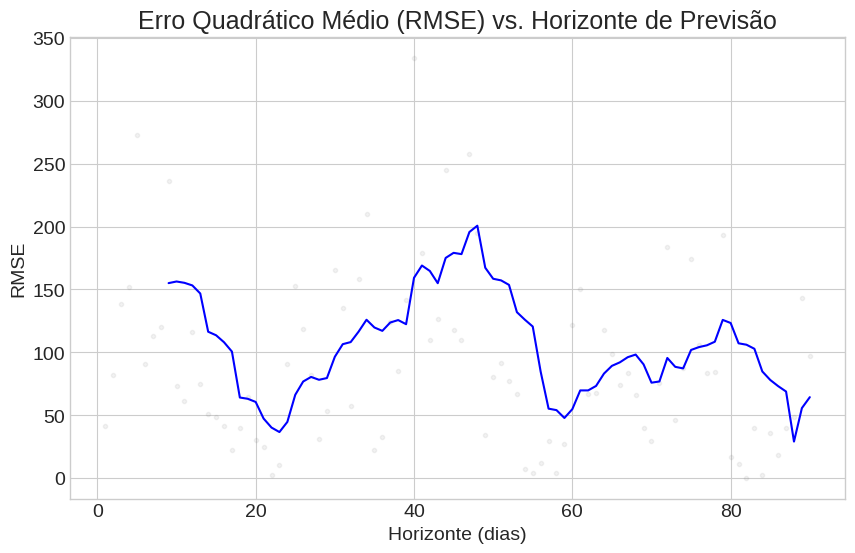

In [24]:
# Célula 15 (Corrigida): Visualizando o Erro (RMSE)

from prophet.plot import plot_cross_validation_metric

if 'df_cv' in locals():
    # Trocamos a métrica de 'mape' para 'rmse', que é robusta a valores zero.
    fig = plot_cross_validation_metric(df_cv, metric='rmse')

    plt.title('Erro Quadrático Médio (RMSE) vs. Horizonte de Previsão', fontsize=18)
    plt.xlabel('Horizonte (dias)', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.show()

In [25]:
# Célula 16: Exportando os Resultados da Previsão para CSV

if 'forecast' in locals():
    # Selecionamos as colunas mais relevantes para a visualização
    output_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Juntamos os dados históricos (y) ao nosso dataframe de saída
    # para que possamos comparar o real vs. previsto no Tableau.
    output_df = pd.merge(output_df, df_prophet, on='ds', how='left')

    # Definimos o caminho de saída no mesmo local do arquivo original
    # Lembre-se que o caminho deve apontar para uma pasta existente.
    caminho_saida = '/content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Análise Preditiva de Vendas (Sales Forecasting)/forecast_results.csv'

    try:
        output_df.to_csv(caminho_saida, index=False)
        print(f"Arquivo de previsão salvo com sucesso em: {caminho_saida}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o arquivo: {e}")

Arquivo de previsão salvo com sucesso em: /content/drive/MyDrive/Projetos/Projetos - Ciência de Dados/Análise Preditiva de Vendas (Sales Forecasting)/forecast_results.csv
